Todo:
- fit style to figs in thesis. so bold fonts fofr axis titles, thicker axis lines, sort legends
- figure out why bombing happend at 2am. is it rare occurences? 
- probs need some statistical model to see if there is a pattern? though im not sure if that really adds much value
- aks agung if they haev any of the missing data gaps/to prioritise these.
- make training performance plots?
- write up!


In [13]:
import os
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [14]:
# Global variables
# Base directory from environment
BASE_DIR = os.getenv("BASE_DIR")
if not BASE_DIR:
    raise ValueError("BASE_DIR must be set")

CSV_FOLDER: str = os.path.join(BASE_DIR, "bomb_fishing/data/mars_outputs")
BOMB_KEYWORDS = {"y", "Y", "yes", "bomb"} # keywords used by team to denote a bomb

### Plot time series

In [15]:

def load_data_by_recorder(csv_folder: str, recorder_prefix: str) -> pd.DataFrame:
    """Load and concatenate CSV files for a given north/south recorder prefix.

    Args:
        csv_folder: Path to the folder containing CSV files.
        recorder_prefix: Prefix of files to load (e.g., 'north' or 'south').

    Returns:
        DataFrame with parsed 'datetime' and 'bomb_detected' columns.
    """
    file_list = [
        os.path.join(csv_folder, f)
        for f in os.listdir(csv_folder)
        if f.lower().startswith(recorder_prefix.lower()) and f.lower().endswith(".csv")
    ]
    if not file_list:
        raise FileNotFoundError(f"No CSV files found for region '{recorder_prefix}'.")
    df_list = [pd.read_csv(fp) for fp in file_list]
    df = pd.concat(df_list, ignore_index=True)
    # Parse datetime from File column
    df["datetime"] = (
        df["File"].str.replace(".WAV", "", regex=False)
        .apply(lambda x: datetime.strptime(x, "%Y%m%d_%H%M%S"))
    )
    # Flag bomb detections
    df["bomb_detected"] = (
        df["Bombs"].astype(str).str.lower().isin(BOMB_KEYWORDS)
    )
    return df


def aggregate_daily_counts(df: pd.DataFrame) -> (pd.Series, pd.Series):
    """Aggregate bomb detections and recording presence by day.

    Args:
        df: DataFrame with 'datetime' and 'bomb_detected'.

    Returns:
        Tuple of two Series indexed by date:
          - bombs_per_day: count of detections per day.
          - recordings_per_day: count of recordings per day.
    """
    df["date"] = df["datetime"].dt.date
    all_dates = pd.date_range(start=df["date"].min(), end=df["date"].max(), freq="D")
    bombs_count = df.loc[df["bomb_detected"]].groupby("date").size()
    recordings_count = df.groupby("date").size()
    bombs_count = bombs_count.reindex(all_dates.date, fill_value=0)
    recordings_count = recordings_count.reindex(all_dates.date, fill_value=0)
    bombs_count.index = pd.to_datetime(bombs_count.index)
    recordings_count.index = pd.to_datetime(recordings_count.index)
    return bombs_count, recordings_count


def find_gap_spans(recordings_count: pd.Series) -> list[tuple[date, date]]:
    """Identify contiguous spans of days with no recordings.

    Args:
        recordings_count: Series indexed by datetime, values are counts per day.

    Returns:
        List of (start_date, end_date) tuples for each gap.
    """
    gap_days = [d.date() for d, c in recordings_count.items() if c == 0]
    if not gap_days:
        return []
    gap_days_sorted = sorted(gap_days)
    spans = []
    start = prev = gap_days_sorted[0]
    for current in gap_days_sorted[1:]:
        if current == prev + timedelta(days=1):
            prev = current
        else:
            spans.append((start, prev))
            start = prev = current
    spans.append((start, prev))
    return spans

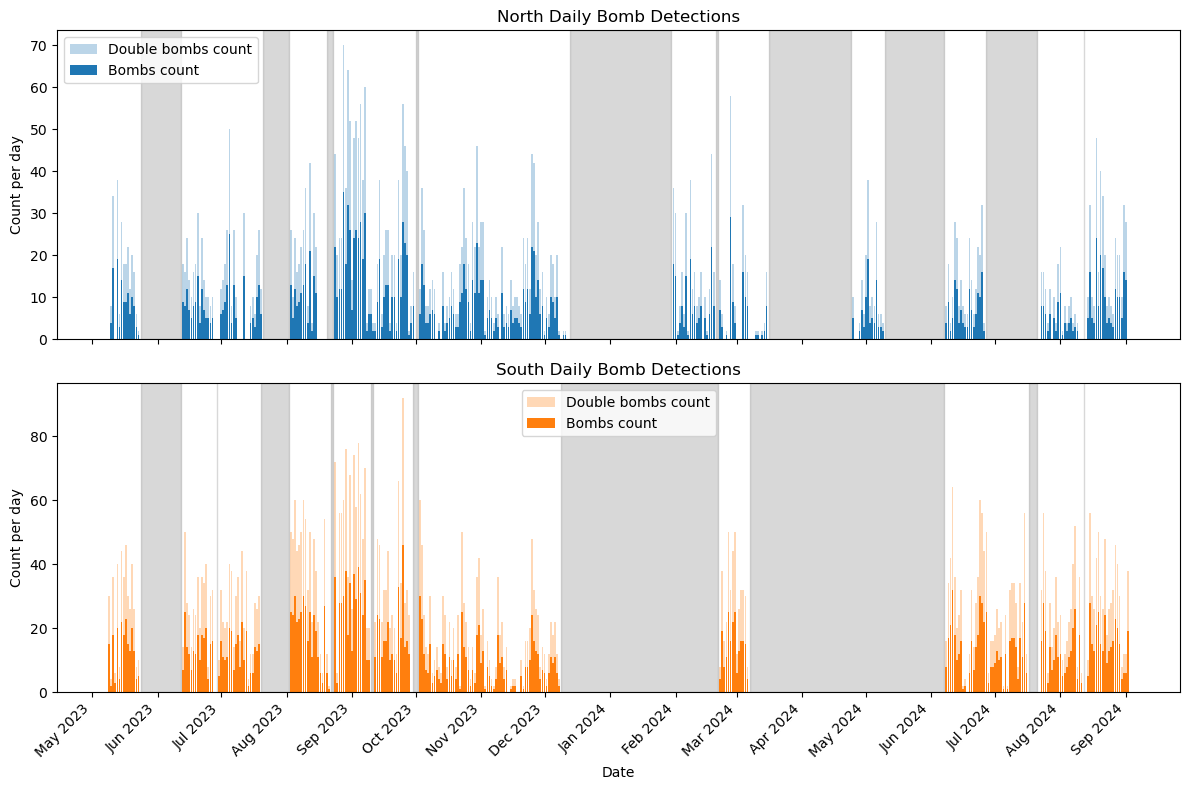

In [16]:
def plot_bomb_time_series(csv_folder: str) -> None:
    """Plot daily bomb counts with recording gaps shaded *between* bars."""
    recorders = ["north", "south"]
    fig, axes = plt.subplots(len(recorders), 1, sharex=True, figsize=(12, 8))
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    bar_width = 0.8                           # days
    half_width = bar_width / 2

    for ax, recorder, color in zip(axes, recorders, colors):
        df = load_data_by_recorder(csv_folder, recorder)
        bombs_count, recordings_count = aggregate_daily_counts(df)
        gap_spans = find_gap_spans(recordings_count)
        dates = bombs_count.index

        # Shade gaps *between* bars, inset by half_width days on each side:
        for start, end in gap_spans:
            ax.axvspan(
                start + timedelta(days=half_width),
                end + timedelta(days=1 - half_width),
                color="grey",
                alpha=0.3,
                zorder=0,
            )

        # Plot the double‐height “background” bars
        ax.bar(
            dates,
            bombs_count * 2,
            width=bar_width,
            color=color,
            alpha=0.3,
            label="Double bombs count",
            zorder=1,
        )
        # Plot the real counts on top
        ax.bar(
            dates,
            bombs_count,
            width=bar_width,
            color=color,
            label="Bombs count",
            zorder=2,
        )

        ax.set_title(f"{recorder.capitalize()} Daily Bomb Detections")
        ax.set_ylabel("Count per day")
        ax.legend()

    # Tidy up dates
    axes[-1].xaxis.set_major_locator(mdates.MonthLocator())
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    fig.autofmt_xdate(rotation=45)
    plt.xlabel("Date")
    fig.tight_layout()
    plt.show()

plot_bomb_time_series(CSV_FOLDER)

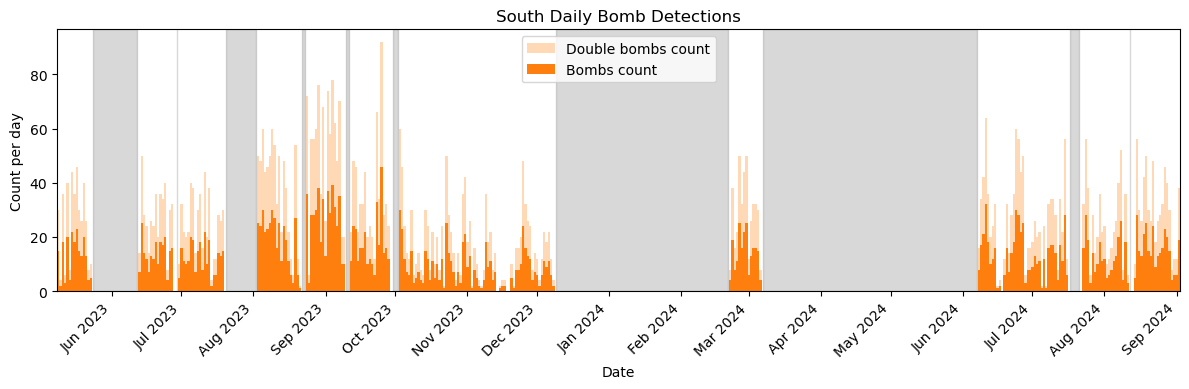

In [17]:
# South-only daily bomb detections


# Parameters
recorder = "south"
bar_width = 1                    # in days
half_width = bar_width / 2
colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
colour = colours[1] # gets that nice contrasting ornage colour

# Load & aggregate
df          = load_data_by_recorder(CSV_FOLDER, recorder)
bombs_count, recordings_count = aggregate_daily_counts(df)
gaps        = find_gap_spans(pd.Series(recordings_count.values, index=bombs_count.index))

# Plot setup
fig, ax = plt.subplots(figsize=(12, 4))

# Shade gaps *between* bars
for start, end in gaps:
    ax.axvspan(
        start + timedelta(days=half_width),
        end   + timedelta(days=1 - half_width),
        color="grey",   # use 'color', not 'colour'
        alpha=0.3,
        zorder=0,
    )

# Double-height “background” bars
ax.bar(
    bombs_count.index,
    bombs_count.values * 2,
    width=bar_width,
    color=colour,    # use 'color'
    alpha=0.3,
    label="Double bombs count",
    zorder=1,
)

# Actual bomb counts
ax.bar(
    bombs_count.index,
    bombs_count.values,
    width=bar_width,
    color=colour,    # use 'color'
    label="Bombs count",
    zorder=2,
)

# Formatting
ax.margins(x=0) # remove extra white space on left/right

ax.set_title("South Daily Bomb Detections")
ax.set_ylabel("Count per day")
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate(rotation=45)
plt.xlabel("Date")
plt.tight_layout()
plt.show()


### Rose plot

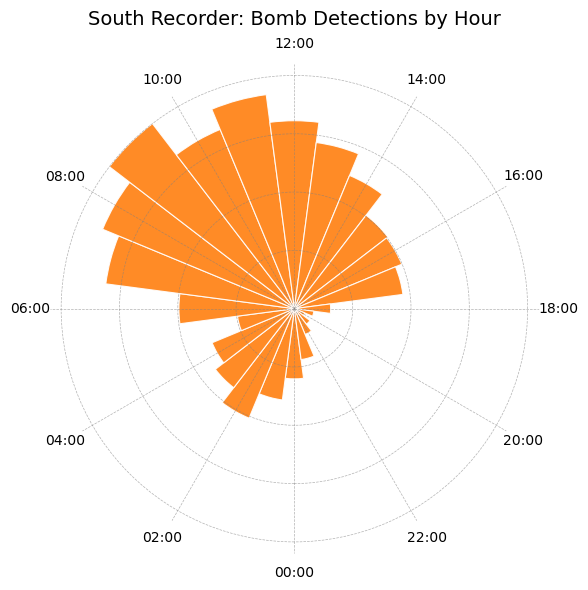

In [19]:
# Rose plot: South Recorder bomb detections by hour,
#   with noon at the top, 2‐hour ticks, and day/night colouring.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from math import pi

# Load & filter for true bomb hits
df = load_data_by_recorder(CSV_FOLDER, "south")
hits = df[df["bomb_detected"]].copy()
hits["hour"] = hits["datetime"].dt.hour

# Count detections by hour (0–23)
hourly_counts = hits.groupby("hour").size().reindex(range(24), fill_value=0)
radii = hourly_counts.values
max_r = radii.max()

# sample 24 colours
colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
bar_colour = colours[1]   

# Compute angles for each hour
N = 24
angles = np.linspace(0, 2*pi, N, endpoint=False)
width = 2*pi / N

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": "polar"})

# Bars
bars = ax.bar(
    angles,
    radii,
    width=width,
    bottom=0,
    color=bar_colour,   
    edgecolor="white",
    linewidth=0.8,
    alpha=0.9,
)

# Aesthetics
ax.set_theta_zero_location("S")   # 0h (midnight) at bottom → 12h (noon) at top
ax.set_theta_direction(-1)        # clockwise increases

# tick every 2 hours
hours = np.arange(0, 24, 2)
ticks = hours * 2*pi/24
ax.set_xticks(ticks)
ax.set_xticklabels([f"{h:02d}:00" for h in hours], fontsize=10)

# lighten grid, remove spine
ax.grid(color="grey", linestyle="--", linewidth=0.5, alpha=0.6)
ax.spines["polar"].set_visible(False)

### Radial ticks
#radials = np.linspace(0, max_r, 5)
#ax.set_yticks(radials)
#ax.set_yticklabels([f"{int(r)}" for r in radials], fontsize=8)
### No radial ticks
radials = np.linspace(0, max_r, 5)
ax.set_yticks(radials)
ax.set_yticklabels([])   # ← hide the numeric labels (77, 154, …) 

ax.set_title("South Recorder: Bomb Detections by Hour", va="bottom", fontsize=14)
plt.tight_layout()
plt.show()


Makassar sits just south of the equator, so daylight hardly budges over the year – you only get about a 36-minute swing from shortest to longest day. At the June solstice (around 21 June) you’ll see roughly 11 h 49 min of light, and at the December solstice (around 21 December) about 12 h 25 min – that’s it, just half an hour or so difference 
Time and Date
Time and Date
.

In day-to-day life the Sun basically pops up at about 6 am and clocks off at about 6 pm. For instance, on 30 May 2025 it rose at 06:04 am and set at 05:55 pm local time 
Time and Date
. Through the year you’ll only ever see sunrises shift by a few minutes (you won’t catch it before about 05:50 am or after about 06:15 am) and sunsets land between roughly 17:45 and 18:15. So, is it much? Nah – barely noticeable unless you’re keeping a stopwatch.

### Plot precision

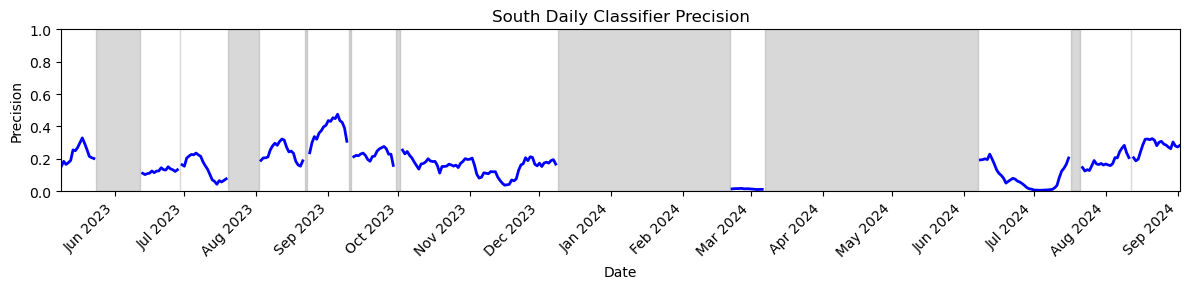

In [20]:
# South-only daily classifier precision plot (masking grey periods)

# Parameters
recorder = "south"
bar_width = 1.0    # days
half_width = bar_width / 2  # inset for shading
smoothing_window = 7   # days for rolling mean

# Load data and add 'date'
df = load_data_by_recorder(CSV_FOLDER, recorder).copy()
df['date'] = df['datetime'].dt.date

# Get daily bomb counts and total detections
bombs_count, recordings_count = aggregate_daily_counts(df)

# Compute daily precision (true positives / hits), avoid divide-by-zero
precision = bombs_count / recordings_count.replace(0, np.nan)

# Smooth precision with rolling mean
smoothed = precision.rolling(
    window=smoothing_window,
    center=True,
    min_periods=1
).mean()

# Mask out days with no recordings so the line skips grey gaps
smoothed[recordings_count == 0] = np.nan

# Identify gaps for shading
gaps = find_gap_spans(recordings_count)

# Plot
fig, ax = plt.subplots(figsize=(12, 3))

# Shade no-recording gaps
for start, end in gaps:
    ax.axvspan(
        start + timedelta(days=half_width),
        end   + timedelta(days=1 - half_width),
        color="grey",
        alpha=0.3,
        zorder=0,
    )

# Plot smoothed precision line
ax.plot(
    smoothed.index,
    smoothed.values,
    color="blue",
    linewidth=2,
    label=f"{smoothing_window}-day rolling precision",
    zorder=1,
)

# Formatting
ax.set_ylim(0, 1)
ax.margins(x=0)
ax.set_title("South Daily Classifier Precision")
ax.set_ylabel("Precision")
#ax.legend(loc="upper right")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate(rotation=45)
plt.xlabel("Date")
plt.tight_layout()
plt.show()


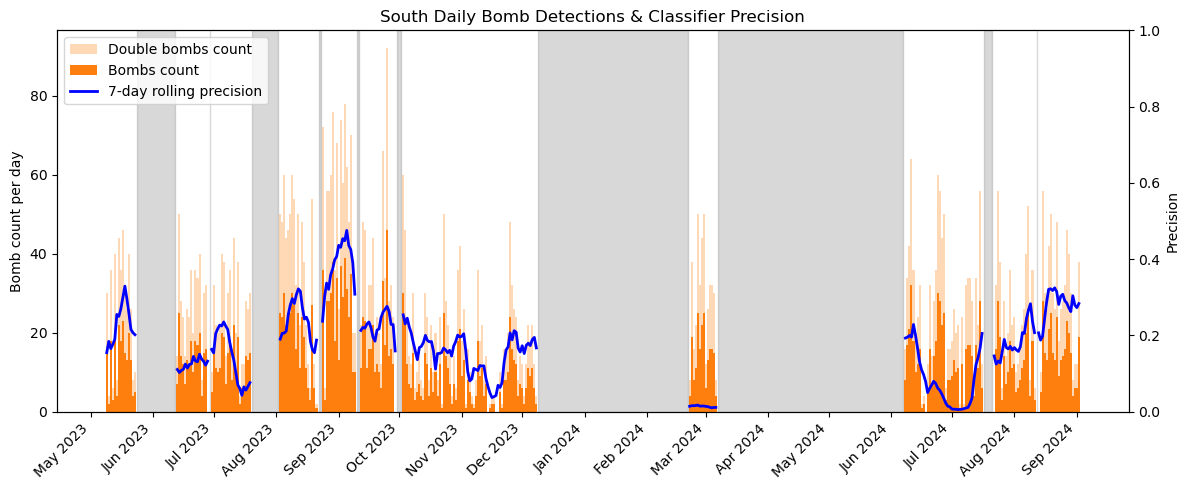

In [21]:
# Combined South bombardment & precision with dual y-axes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

# Parameters
recorder         = "south"
bar_width        = 1.0                      # width of each bar in days
half_width       = bar_width / 2            # inset for gap shading
smoothing_window = 7                        # days for rolling mean
colours          = plt.rcParams["axes.prop_cycle"].by_key()["color"]
bar_colour       = colours[1]               # orange
line_colour      = "blue"                   # precision line

# 1) Load & prepare data
df = load_data_by_recorder(CSV_FOLDER, recorder).copy()
df["date"] = df["datetime"].dt.date

# 2) Daily bomb counts (true positives) and recording hits (all entries)
daily_hits = df.groupby("date").size()                      # total flagged hits/day
daily_true = df[df["bomb_detected"]].groupby("date").size() # validated bombs/day

# 3) Align to full date range
all_days = pd.date_range(daily_hits.index.min(), daily_hits.index.max(), freq="D").date
hits = daily_hits.reindex(all_days, fill_value=0)
true = daily_true.reindex(all_days, fill_value=0)
dates = pd.to_datetime(all_days)

# 4) Compute precision only on days with hits
precision = true / hits.replace(0, np.nan)

# 5) Smooth precision
smoothed = precision.rolling(window=smoothing_window, center=True, min_periods=1).mean()

# 6) Identify no‐recording gaps for shading
_, recordings_count = aggregate_daily_counts(df)
gaps = find_gap_spans(recordings_count)

# 7) Break the line over gaps: mask smoothed where no recordings
smoothed[recordings_count == 0] = np.nan

# 8) Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()

# 9) Shade gaps on ax1 (covers background of both axes)
for start, end in gaps:
    ax1.axvspan(
        start + timedelta(days=half_width),
        end   + timedelta(days=1 - half_width),
        color="grey",
        alpha=0.3,
        zorder=0,
    )

# 10) Plot bomb counts on ax1
ax1.bar(
    dates,
    true.values * 2,        # double-height background
    width=bar_width,
    color=bar_colour,
    alpha=0.3,
    label="Double bombs count",
    zorder=1,
)
ax1.bar(
    dates,
    true.values,
    width=bar_width,
    color=bar_colour,
    label="Bombs count",
    zorder=2,
)

# 11) Plot precision line on ax2
ax2.plot(
    dates,
    smoothed.values,
    color=line_colour,
    linewidth=2,
    label=f"{smoothing_window}-day rolling precision",
    zorder=3,
)

# 12) Formatting
ax1.margins(x=0)             # no extra x-margins
ax1.set_ylabel("Bomb count per day")
ax2.set_ylabel("Precision")
ax2.set_ylim(0, 1)           # precision between 0 and 1
ax1.set_title("South Daily Bomb Detections & Classifier Precision")

# Legends: combine handles from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left")

# X-axis date formatting
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate(rotation=45)
plt.xlabel("Date")

plt.tight_layout()
plt.show()


### Print recording len and bomb count
This is total time that ahs passed between the start of deployment and end. So later we cut in half to get the true recording time due to 1 in 2 min duty cycle.

In [22]:
def get_recording_periods(csv_folder: str, recorder_prefix: str) -> pd.DataFrame:
    """Compute start and end datetimes for each CSV (continuous recording period).

    Args:
        csv_folder: Path to CSV folder.
        recorder_prefix: 'north' or 'south'.

    Returns:
        DataFrame with columns ['file', 'start', 'end', 'duration'].
    """
    records = []
    for fname in os.listdir(csv_folder):
        if not fname.lower().startswith(recorder_prefix.lower()) or not fname.lower().endswith('.csv'):
            continue
        path = os.path.join(csv_folder, fname)
        tmp = pd.read_csv(path)
        # parse first and last datetime
        times = (
            tmp['File'].str.replace('.WAV', '', regex=False)
            .apply(lambda x: datetime.strptime(x, '%Y%m%d_%H%M%S'))
        )
        start, end = times.min(), times.max()
        duration = end - start
        records.append({'file': fname, 'start': start, 'end': end, 'duration': duration})
    return pd.DataFrame(records)


def print_summary(csv_folder: str) -> None:
    """Print bomb totals and bombs-per-recording-day rate for each site."""
    for site in ['north', 'south']:
        # Load data and periods
        df = load_data_by_recorder(csv_folder, site)
        periods = get_recording_periods(csv_folder, site)

        # Total bombs
        raw = int(df['bomb_detected'].sum())
        doubled = raw * 2

        # Overall span
        start = periods['start'].min().date()
        end   = periods['end'].max().date()
        days_total = (end - start).days + 1

        # Total audio duration adjusted for duty cycle
        total_dur = periods['duration'].sum() / 2  # a timedelta
        days_rec  = total_dur.total_seconds() / (3600 * 24)  # float days

        # Simple rate: bombs per recording-day
        bombs_per_rec_day = raw / days_rec if days_rec > 0 else float('nan')

        # Print summary
        print(f"{site.capitalize()} site:")
        print(f"  Period: {start} → {end} ({days_total} days inclusive)")
        print(f"  Bombs detected: {raw} (×2 → {doubled})")
        print(f"  Recording-days (adjusted): {days_rec:.2f}")
        print(f"  Bombs per recording-day: {bombs_per_rec_day:.2f}\n")


print_summary(CSV_FOLDER)

North site:
  Period: 2023-05-10 → 2024-09-01 (481 days inclusive)
  Bombs detected: 2296 (×2 → 4592)
  Recording-days (adjusted): 169.54
  Bombs per recording-day: 13.54

South site:
  Period: 2023-05-09 → 2024-09-02 (483 days inclusive)
  Bombs detected: 3567 (×2 → 7134)
  Recording-days (adjusted): 154.12
  Bombs per recording-day: 23.14

